In [1]:
import astropy
import numpy as np
import scipy
import numpy
import pyspeckit
import zipfile
import os
import re
import matplotlib.pyplot as plt
from astropy.table import QTable,Table,Column
from astropy.io import ascii
from sklearn.metrics import auc
from openpyxl import load_workbook
import xlrd
from tabulate import tabulate

In [2]:
def Filterdat(lista): #filtrar datos de directorios por ".dat"
    return [name for name in lista if re.search(r'dat', name)]

def colxfil(mat): #en una tabla, o matriz, cambiar filas por columnas
    num=[i for i in range(len(mat[0]))]
    aux=[]
    mat2=[]
    for pos in num:
        aux=[]
        for lista in mat:
            aux.append(lista[pos])
        
        mat2.append(aux)
    return mat2

#def norm(lista): #normalizacion de datos por preprocessing
#    return preprocessing.normalize(lista)

def norm(lista): #normalización de datos por maximos y minimos
    a=[]
    for f in lista:
        a.append((f-min(lista))/(max(lista)-min(lista)))
    return a

def unique(lista):
    uni=[]
    for l in lista:
        if l not in uni:
            uni.append(l)
    return uni

def recta2(punto1,punto2,evaluar): #crea valores entre 2 puntos en funcion de un conjunto externo
    x1=punto1[0]
    y1=punto1[1]
    x2=punto2[0]
    y2=punto2[1]
    if x2!=x1:
        m=(y2-y1)/(x2-x1)
    if x2==x1:
        pass
    c=y1-(m*x1)
    return (m*evaluar)+c 
def MtoL(value):
    M_sun=4.83
    L_sun=3.8*(10**33)
    return L_sun*10**((value-M_sun)/(-2.5))

def LtoM(value):
    M_sun=4.83
    L_sun=3.8*(10**33)
    
    return (-M_sun-2.5*np.log10(value/(L_sun)))

def convol(espectra, filtro): #entrada de variables
    
    #parte 1: separar datos y limites
    espec=[]
    fl=[]
    espec_wl=[]
    fl_wl=[]
    coords1=[]
    coords2=[]
    for pair in espectra: #guardado de datos para crear tabala general en base a los "S" y "F"
        espec.append((float(pair[0]),float(pair[1]),'S'))
        coords1.append((float(pair[0]),float(pair[1])))
        espec_wl.append(float(pair[0]))
    for pair in filtro:
        fl.append((float(pair[0]),float(pair[1]),'F'))
        coords2.append((float(pair[0]),float(pair[1])))
        fl_wl.append(float(pair[0])) #limites 
    
    
    minimum=min(fl_wl) #limite minimo
    maximum=max(fl_wl) #limite maximo
    
    wl=(sorted(espec+fl)) #conjunto ordenado en funcion de la longitud de onda
    no_existe_en_spec=[value for value in fl_wl if  value not in espec_wl]
    no_existe_en_fil=[value for value in espec_wl if  value not in fl_wl]
    
    #parte 2: generar tabla final con datos
    final_table=Table() 
    final_table['Wavelength']=([w[0] for w in wl]) #tabla general
    final_table['Spectra']=[None for i in wl]
    final_table['Filter']=[None for i in wl]
    
    for wave,tri in zip(final_table['Wavelength'],wl):
        indice_wl=list(final_table['Wavelength']).index(wave) #fila
        if tri[2]=='S': #ordenar segun indice "S"pectra
            final_table['Spectra'][indice_wl]=tri[1]
        if tri[2]=='F': #ordenar segun indice "F"ilter
            final_table['Filter'][indice_wl]=tri[1]
    
    #parte 3: quitar vacios repetidos                                              
    general=[]
    vacios=[]
    for tri in final_table:
        general.append(tri)
        if tri['Spectra']==None and tri['Filter']==None:
            vacios.append(tri)
    for tri in vacios:
        general.remove(tri)
     
       
    #parte 4: tabla reducida
    tabla_redu=Table()
    WL=[]
    SP=[]                                              
    FL=[]
    for tri in general:
        WL.append(tri['Wavelength'])
        SP.append(tri['Spectra'])
        FL.append(tri['Filter'])
    
    tabla_redu['Wavelength']=WL
    tabla_redu['Spectra']=SP                                            
    tabla_redu['Filter']=FL 
    
    
    #parte 5: rellenar
    
    #spectra
    indices1=[coords1.index(value) for value in coords1]
    
    valores=[]
    lambda_A=[]
    for index in indices1[:len(indices1)-1]:
        puntos=[coords1[index],coords1[index+1]]
        
        for value in no_existe_en_spec:
            if value>puntos[0][0] and value<puntos[1][0]:
                aux=recta2(puntos[0],puntos[1],value)
                lambda_A.append(value)
                valores.append([value,aux])
    
    SP_ind=[list(tabla_redu['Wavelength']).index(value) for value in lambda_A]
    for pair,ind in zip(valores,SP_ind):
        if tabla_redu['Spectra'][ind]==None:
            tabla_redu['Spectra'][ind]=pair[1]
    
    
    
    
   #filtro
    indices2=[coords2.index(value) for value in coords2]
    
    valores=[]
    lambda_B=[]
    for index in indices2[:len(indices2)-1]:
        puntos=[coords2[index],coords2[index+1]]
        
        for value in no_existe_en_fil:
            if value>puntos[0][0] and value<puntos[1][0]:
                aux=recta2(puntos[0],puntos[1],value)
                lambda_B.append(value)
                valores.append([value,aux])
    
    FL_ind=[list(tabla_redu['Wavelength']).index(value) for value in lambda_B]
    for pair,ind in zip(valores,FL_ind):
        if tabla_redu['Filter'][ind]==None:
            tabla_redu['Filter'][ind]=pair[1]

    tabla_redu=tabla_redu[tabla_redu['Wavelength']>=minimum]
    tabla_redu=tabla_redu[tabla_redu['Wavelength']<=maximum]

    
    Tabla_salida=Table()
    Tabla_salida['WL']=tabla_redu['Wavelength']
    Tabla_salida['Spectra']=tabla_redu['Spectra']*tabla_redu['Filter']*tabla_redu['Wavelength']
    
    superior=auc(Tabla_salida['WL'],Tabla_salida['Spectra'])
    inferior=auc(tabla_redu['Wavelength'],(tabla_redu['Filter']*tabla_redu['Wavelength']))
    
    Luminosidad=(superior/inferior)
    return Luminosidad

In [6]:

M_sun=4.83
L_sun=3.8*(10**33)
value = 0.46*L_sun
(-M_sun-2.5*np.log10(value/(L_sun)))

-3.9868945792039354

In [81]:
#data
datos=sorted(os.listdir('simulations'))
datos=(datos[1:len(datos)])
#print(datos)

search2=''
while search2 not in datos:
    print(f'The options are: ')
    for value in datos:
        if value=='.DS_Store':
            pass
        else:
            print(f'{value}')
    search2=str(input('File name: >'))
    if search2 in datos:
        pass

aux0=sorted(os.listdir(f'simulations/{search2}'))
dts=[]
for value in aux0:
    if value=='.DS_Store':
        continue
    dts.append(value)


subdatos=dts

#print(subdatos)
search3=''
while search3 not in subdatos:
    print(f'\nThe options are: ')
    for value in subdatos:
        print(f'{value}')
    search3=str(input('File name: >'))
    if search3 in datos:
        pass
    
aux1=sorted(os.listdir(f'simulations/{search2}/{search3}'))
dts2=[value for value in aux1]
variables=['color','hires','ifaspec','input','output','ovil','spectrum','timeused']

search4=''
while search4 not in variables:
    print(f'\nThe options are: ')
    for archivo,variable in zip(dts2,variables):
        print(f'If {archivo}: say "{variable}"')
    search4=str(input('Name:'))
indice=dts2[variables.index(search4)]

topen=f'simulations/{search2}/{search3}/{indice}'

#######Filtros########

filtros=os.listdir(f'splus_filters-master')
Filtros=(Filterdat(filtros))
paths=[f'splus_filters-master/'+name for name in Filtros]

Tablas_general_filtros=[] #12 tablas
for value in paths:
    auxiliar1=(astropy.io.ascii.read(value))
    Tablas_general_filtros.append(auxiliar1) #12 tablas con datos de los filtros, col1: longitud de onda / col2: flujo
for table in Tablas_general_filtros:
    table['col2']=table['col2']*100 #col1 y col2, nombres de columnas
    
Wide=[i for i in Filtros if re.search(r'SDSS',i) or re.search(r'JAVA',i)] #2,4,5,6(JAVA),8 
index_filter=[]
for fil in Wide:
    index_filter.append(Filtros.index(fil))

wideband=[]
for num in index_filter:
    wideband.append(Tablas_general_filtros[num])
G=wideband[0]
R=wideband[1]
Z=wideband[2]
I=wideband[4]
U=wideband[3]

The options are: 
Archivos
Belen
Jose
Seba
Vale
extra
new
File name: >Seba

The options are: 
.ipynb_checkpoints
TMP10897.tar.gz
TMP15465.tar.gz
TMP2166.tar.gz
TMP50090.tar.gz
TMP5244.tar.gz
TMP71730.tar.gz
output 
output 2
output 3
output 4
output 5
output 6
File name: >output

The options are: 
.ipynb_checkpoints
TMP10897.tar.gz
TMP15465.tar.gz
TMP2166.tar.gz
TMP50090.tar.gz
TMP5244.tar.gz
TMP71730.tar.gz
output 
output 2
output 3
output 4
output 5
output 6
File name: >output 

The options are: 
If .DS_Store: say "color"
If Tidal10.color1: say "hires"
If Tidal10.hires1: say "ifaspec"
If Tidal10.ifaspec1: say "input"
If Tidal10.input1: say "output"
If Tidal10.output1: say "ovil"
If Tidal10.ovi1: say "spectrum"
If Tidal10.spectrum1: say "timeused"
Name:spectrum


In [82]:
#revisar los mios
#belen y vale 1 año dispar
#seba todo correcto
Wide

['gSDSS.dat', 'rSDSS.dat', 'zSDSS.dat', 'uJAVA.dat', 'iSDSS.dat']

In [86]:
#abre cualquier archivo de los marcados
Data=ascii.read(topen, format='basic', header_start=3, data_start=4)



if search4=='spectrum': #para datos de espectro
    edades=unique(Data['TIME[YR]']) 
    tablas_por_edad=[Table() for i in edades]
    #tarda un ratito en correr, es normal
    wl=[]
    spectro=[]

    for edad,tabla in zip(edades,tablas_por_edad):
        wl=[]
        spectro=[]

        for fila in Data:
            if edad==fila['TIME[YR]']:
                print(fila)
                wl.append(fila['WAVELENGTH'])
                spectro.append(10**(fila['LOG_STELLAR']))
        tabla['WL']=wl
        tabla['Spectra']=spectro



  TIME[YR]  WAVELENGTH LOG(LUMINOSITY) NORMALIZED_SPECTRUM
----------- ---------- --------------- -------------------
100000000.0     1003.1         37.0097                 1.0


KeyError: 'LOG_STELLAR'

KeyError: 'WL'

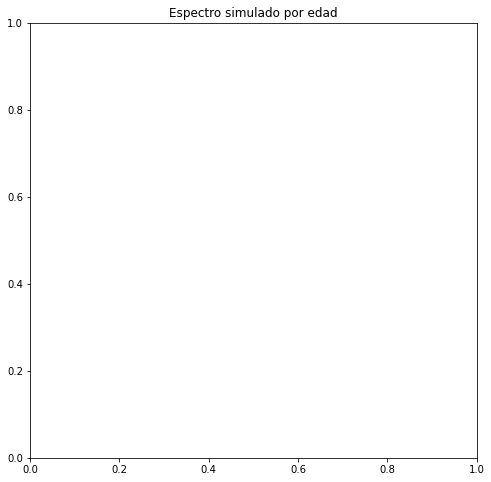

In [87]:
fig = plt.figure(figsize=(8,8))
plt.title('Espectro simulado por edad')
for tabla in tablas_por_edad:
    plt.plot(np.log10(tabla['WL']),(tabla['Spectra']))
#for band in wideband:
    #plt.plot(np.log10(band['col1']),(band['col2']))
plt.xlabel('Longitud de onda')
plt.ylabel('Flujo normalizado')
plt.savefig('Espectro simulado por edad.png',format='png')
plt.show()

In [60]:
for x in tablas_por_edad:
    print(max(x['Spectra']))

1.7588953469236637e+39
1.6279835041323663e+39
1.509384896654961e+39
1.3962719066782195e+39
1.2972987511122211e+39
1.2117694520325693e+39
1.1389377818757066e+39
1.0706314580938196e+39
1.0102991788408906e+39
9.548826447656653e+38
9.081759565209852e+38
8.635549938528961e+38
8.216559414313931e+38
7.829787941890972e+38
7.506197721122598e+38
7.220877876048657e+38
6.933938733133747e+38
6.6378892173252104e+38
6.3319867877872494e+38
6.0278161812695065e+38
5.651841838210069e+38
5.302491731901049e+38
4.972216151840506e+38
4.6796136596985096e+38
4.399365046870416e+38
4.126292400152302e+38
3.929614973731511e+38
3.7139837567124584e+38
3.5232219257026166e+38
3.4360541546330635e+38
3.3846206515364452e+38
3.335339140657347e+38
3.2851862769371474e+38
3.2361601075961262e+38
3.1919788128096917e+38
3.144054024906017e+38
3.0987033381639262e+38
3.0543584277771207e+38
3.0098856748206456e+38
2.9681783978430682e+38
2.92745346348633e+38
2.886489619422292e+38
2.8462300529766483e+38
2.8065320103554287e+38
2.770511

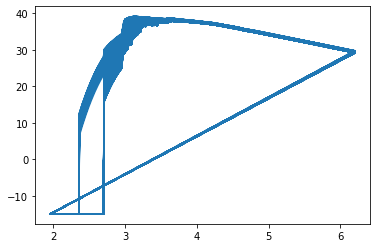

In [61]:
plt.plot(np.log10(Data['WAVELENGTH[A]']),Data['LOG_TOTAL'])
plt.show()

In [62]:
convol_U=[]
for edad,datos_edad in zip(edades,tablas_por_edad):
    aux=convol(datos_edad,U)
    print(f'For U and {edad}: {aux}')
    convol_U.append(aux)

For U and 100000000.0: 4.073403543042364e+38
For U and 105000000.0: 3.875316119431784e+38
For U and 110000000.0: 3.689290999119536e+38
For U and 115000000.0: 3.5153714829852666e+38
For U and 120000000.0: 3.354546277426718e+38
For U and 125000000.0: 3.214208657306613e+38
For U and 130000000.0: 3.0816012655321647e+38
For U and 135000000.0: 2.95169929965027e+38
For U and 140000000.0: 2.832412979374909e+38
For U and 145000000.0: 2.7184713488790377e+38
For U and 150000000.0: 2.6109483608206926e+38
For U and 155000000.0: 2.5113429666983403e+38
For U and 160000000.0: 2.4190547136371748e+38
For U and 165000000.0: 2.3308876011191578e+38
For U and 170000000.0: 2.2490721948328275e+38
For U and 175000000.0: 2.1673050299288076e+38
For U and 180000000.0: 2.091039982388006e+38
For U and 185000000.0: 2.0216776036185974e+38
For U and 190000000.0: 1.9581058479243793e+38
For U and 195000000.0: 1.899401435642591e+38
For U and 200000000.0: 1.8494653402954137e+38
For U and 205000000.0: 1.8012384525193408e+3

In [63]:
convol_G=[]
for edad,datos_edad in zip(edades,tablas_por_edad):
    aux=convol(datos_edad,G)
    print(f'For G and {edad}: {aux}')
    convol_G.append(aux)

For G and 100000000.0: 4.457331927777075e+38
For G and 105000000.0: 4.30303777185648e+38
For G and 110000000.0: 4.159483172261848e+38
For G and 115000000.0: 4.028955758889571e+38
For G and 120000000.0: 3.907271997773075e+38
For G and 125000000.0: 3.797081351857001e+38
For G and 130000000.0: 3.692939223377974e+38
For G and 135000000.0: 3.590345348401282e+38
For G and 140000000.0: 3.492959221644485e+38
For G and 145000000.0: 3.3981959049812648e+38
For G and 150000000.0: 3.303580568551991e+38
For G and 155000000.0: 3.2169301502365077e+38
For G and 160000000.0: 3.136635797380433e+38
For G and 165000000.0: 3.059213166758733e+38
For G and 170000000.0: 2.9835385463584078e+38
For G and 175000000.0: 2.903933115157603e+38
For G and 180000000.0: 2.8318779438268627e+38
For G and 185000000.0: 2.768791134119348e+38
For G and 190000000.0: 2.712401536344222e+38
For G and 195000000.0: 2.6620167509932214e+38
For G and 200000000.0: 2.62731790102598e+38
For G and 205000000.0: 2.5927918388374076e+38
For G 

In [64]:
convol_R=[]
for edad,datos_edad in zip(edades,tablas_por_edad):
    aux=convol(datos_edad,R)
    print(f'For R and {edad}: {aux}')
    convol_R.append(aux)

For R and 100000000.0: 2.5397768714702464e+38
For R and 105000000.0: 2.4517868370987093e+38
For R and 110000000.0: 2.372265207628286e+38
For R and 115000000.0: 2.301109150726108e+38
For R and 120000000.0: 2.232499248873907e+38
For R and 125000000.0: 2.1693078243552074e+38
For R and 130000000.0: 2.1097343512364754e+38
For R and 135000000.0: 2.052435736000733e+38
For R and 140000000.0: 1.998095917341688e+38
For R and 145000000.0: 1.9455940299296406e+38
For R and 150000000.0: 1.8932896999131252e+38
For R and 155000000.0: 1.8453738436141143e+38
For R and 160000000.0: 1.801618727468899e+38
For R and 165000000.0: 1.759415223216973e+38
For R and 170000000.0: 1.7182850473909774e+38
For R and 175000000.0: 1.6757721483529935e+38
For R and 180000000.0: 1.6370230904323905e+38
For R and 185000000.0: 1.6026661414933751e+38
For R and 190000000.0: 1.5709420391551791e+38
For R and 195000000.0: 1.5425774219560418e+38
For R and 200000000.0: 1.5212814988688954e+38
For R and 205000000.0: 1.5004471140056352

In [65]:
convol_Z=[]
for edad,datos_edad in zip(edades,tablas_por_edad):
    aux=convol(datos_edad,Z)
    print(f'For Z and {edad}: {aux}')
    convol_Z.append(aux)

For Z and 100000000.0: 1.2041259279865978e+38
For Z and 105000000.0: 1.1656852080176032e+38
For Z and 110000000.0: 1.1341297555983253e+38
For Z and 115000000.0: 1.1074597671859175e+38
For Z and 120000000.0: 1.0810746327631659e+38
For Z and 125000000.0: 1.052291340418483e+38
For Z and 130000000.0: 1.0243494006534668e+38
For Z and 135000000.0: 9.971121009718636e+37
For Z and 140000000.0: 9.715393604517808e+37
For Z and 145000000.0: 9.462884878135463e+37
For Z and 150000000.0: 9.213636212879786e+37
For Z and 155000000.0: 8.990234630579015e+37
For Z and 160000000.0: 8.781873565888808e+37
For Z and 165000000.0: 8.585117911677436e+37
For Z and 170000000.0: 8.389325157609719e+37
For Z and 175000000.0: 8.195032411711823e+37
For Z and 180000000.0: 8.014863021793681e+37
For Z and 185000000.0: 7.852938376935768e+37
For Z and 190000000.0: 7.697649809315472e+37
For Z and 195000000.0: 7.558638390409151e+37
For Z and 200000000.0: 7.437823662111413e+37
For Z and 205000000.0: 7.32884116609045e+37
For Z

In [67]:
convol_I=[]
for edad,datos_edad in zip(edades,tablas_por_edad):
    aux=convol(datos_edad,I)
    print(f'For I and {edad}: {aux}')
    convol_I.append(aux)

For I and 100000000.0: 1.6321764500954673e+38
For I and 105000000.0: 1.5753028123912532e+38
For I and 110000000.0: 1.5258794252655134e+38
For I and 115000000.0: 1.4821574619711427e+38
For I and 120000000.0: 1.4400807438826505e+38
For I and 125000000.0: 1.3992443844473874e+38
For I and 130000000.0: 1.3603787057574489e+38
For I and 135000000.0: 1.323255168405798e+38
For I and 140000000.0: 1.2883894001900037e+38
For I and 145000000.0: 1.2545815961236545e+38
For I and 150000000.0: 1.2212330138984985e+38
For I and 155000000.0: 1.1907316894240094e+38
For I and 160000000.0: 1.1629524297026605e+38
For I and 165000000.0: 1.1361579233984495e+38
For I and 170000000.0: 1.1099833950941178e+38
For I and 175000000.0: 1.0834649140241504e+38
For I and 180000000.0: 1.058937873077734e+38
For I and 185000000.0: 1.0371119911635537e+38
For I and 190000000.0: 1.016353948229213e+38
For I and 195000000.0: 9.979221240819597e+37
For I and 200000000.0: 9.828569479695596e+37
For I and 205000000.0: 9.68563211429284

In [68]:
MU=[(f'{edad},{LtoM(value)}') for value,edad in zip(convol_U,edades)]
MG=[(f'{edad},{LtoM(value)}') for value,edad in zip(convol_G,edades)]
MR=[(f'{edad},{LtoM(value)}') for value,edad in zip(convol_R,edades)]
MZ=[(f'{edad},{LtoM(value)}') for value,edad in zip(convol_Z,edades)]
MI=[(f'{edad},{LtoM(value)}') for value,edad in zip(convol_I,edades)]
Ms=[MU,MG,MR,MZ,MI]
Fs=['U','G','R','Z','I']



In [69]:
###zona para escribir archivos de convolucion###
head='Edad,Magnitud'

for magnitud,filtro in zip(Ms,Fs):
        with open(f'simulations/{search2}/{search3}/{filtro}_{search2}_{search3}.txt','w') as cv:
            cv.write(head)
            cv.write('\n')
            for line in magnitud:
                cv.write(line)
                cv.write('\n')



In [8]:
151201/5

30240.2

In [55]:
###zona para escribir archivos de convolucion###
head='Edad,Magnitud'


with open(f'simulations/{search2}/{search3}/U_{search2}_{search3}.txt','w') as cv:
    cv.write(head)
    cv.write('\n')
    for value in MU:
        cv.write(value)
        cv.write('\n')

In [17]:
M_sun=4.83
L_sun=3.8*(10**33)
2.5*np.log10(L_sun) + M_sun

79.11945899154202

In [16]:
import numpy as np
M_sun=4.83
L_sun=3.8*(10**33)
Valor_arbitrario = (10**(0))  
(-M_sun-2.5*np.log10(Valor_arbitrario/(L_sun)))

79.11945899154202